#### Imports

In [1]:
project_root_dir = "../../../"

import os
work_dir = os.path.abspath(project_root_dir)

import sys
sys.path.append(project_root_dir)

import wandb
import re

import pandas as pd
from IPython.display import display, HTML
from functools import reduce

import numpy as np

from src.utils import evaluation_helpers
from src.datamodules import IEGenericOutputDataset
from src.utils import get_linearization_class

import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

sns.set_theme(style="whitegrid")
sns.set_style("ticks")
sns.set_palette("deep")

In [2]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

## The Part to Update

In [29]:
# Helper for getting the desired wandb run names and wandb paths

def get_runs(prefix, lp, constraint, datamodule=None):
    api = wandb.Api()
    entity, project = "epfl-dlab", "SynthIE"  # set to your entity and project 
    runs = api.runs(entity + "/" + project) 
    run_name2wandb_path = {}
    for run in runs:
        if run.name.startswith(prefix) and f"constraint-{constraint}" in run.name and f"lp-{lp}" in run.name:
            if datamodule is None or f"datamodule-{datamodule}" in run.name:
                run_name2wandb_path[run.name] = f"{entity}/{project}/{run.id}"

    return run_name2wandb_path

# prefixes = ["inf_fe_fully_synthetic_gcp_large_last", "inf_sc_fully_synthetic_gcp", "inf_full_fe_"]
prefixes = ['inf_full_fe_', 'inf_full_final']
constraints = ["R-max-T5"]
lps = ["0.8"]
datamodules = ["rebel", 'sdg_text', 'sdg_code']
for prefix in prefixes:
    print(f"Prefix: {prefix}")
    run_name2wandb_path = {}
    for constraint in constraints:
        for lp in lps:
            for datamodule in datamodules:
                if "sdg_" in datamodule and "inf_full_fe_" in prefix:
                    continue
                run_name2wandb_path.update(get_runs(prefix, lp, constraint, datamodule))
    pprint(run_name2wandb_path)
    print()

Prefix: inf_full_fe_
{'inf_full_fe_fully_synthetic_ms_base_medium_lr_datamodule-rebel_world-genie_t5_tokenizeable_split-test_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/2mlj6x38',
 'inf_full_fe_rebel_ms_base_medium_lr_datamodule-rebel_world-genie_t5_tokenizeable_split-test_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/2h4ibqlg'}

Prefix: inf_full_final
{'inf_full_final_fe_fully_synthetic_gcp_large_last_datamodule-rebel_world-genie_t5_tokenizeable_split-test_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/cx55mnru',
 'inf_full_final_fe_fully_synthetic_gcp_large_last_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/3hvn11mw',
 'inf_full_final_fe_fully_synthetic_gcp_large_last_datamodule-sdg_text_davinci_003_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/o5empag8',
 'inf_full_final_fe_fully_synthetic_ms_base_medium_lr_datamodule-sdg_code_davinci_002_world-gen

In [30]:
run_name2wandb_path = {
# [Rebel] 
# GenIE-FE (base)
'inf_full_fe_rebel_ms_base_medium_lr_datamodule-rebel_world-genie_t5_tokenizeable_split-test_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/2h4ibqlg',
# SynthIE-FE (base)
'inf_full_fe_fully_synthetic_ms_base_medium_lr_datamodule-rebel_world-genie_t5_tokenizeable_split-test_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/2mlj6x38', 
# SynthIE-FE (large)
'inf_full_final_fe_fully_synthetic_gcp_large_last_datamodule-rebel_world-genie_t5_tokenizeable_split-test_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/cx55mnru',

# [SDG-Text]
# GenIE-FE (base)
'inf_full_final_fe_rebel_ms_base_medium_lr_datamodule-sdg_text_davinci_003_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/jr4d9aa3',
# SynthIE-FE (base)
'inf_full_final_fe_fully_synthetic_ms_base_medium_lr_datamodule-sdg_text_davinci_003_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/250e8fy8',
# SynthIE-FE (large)
'inf_full_final_fe_fully_synthetic_gcp_large_last_datamodule-sdg_text_davinci_003_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/o5empag8',

# [SDG-Code]
## GenIE-FE (base)
'inf_full_final_fe_rebel_ms_base_medium_lr_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/zts0cqgk',
## SynthIE-FE (base)
'inf_full_final_fe_fully_synthetic_ms_base_medium_lr_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/2fy0xmbw', 
## SynthIE-FE (large)
'inf_full_final_fe_fully_synthetic_gcp_large_last_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/3hvn11mw'

# # Old runs
# 'inf_full_fe_fully_synthetic_ms_base_medium_lr_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/1q7a7y10',
# 'inf_fe_fully_synthetic_gcp_large_last_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_small_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/w2qbchl7',
# 'inf_full_fe_rebel_ms_base_medium_lr_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8': 'epfl-dlab/SynthIE/2qn8stqa',

}


# Useful for the process_results launcher
print(" ".join(list(run_name2wandb_path.values())[::-1]))

epfl-dlab/SynthIE/3hvn11mw epfl-dlab/SynthIE/2fy0xmbw epfl-dlab/SynthIE/zts0cqgk epfl-dlab/SynthIE/o5empag8 epfl-dlab/SynthIE/250e8fy8 epfl-dlab/SynthIE/jr4d9aa3 epfl-dlab/SynthIE/cx55mnru epfl-dlab/SynthIE/2mlj6x38 epfl-dlab/SynthIE/2h4ibqlg


In [31]:
# ~~~ Which experiments to consider? ~~~
# model_id_wandb_run_path_pairs = [("R", "martinj96/SynthIE/izr0vgpw"), ("R+S", "martinj96/SynthIE/2f857wrl"), ("R", "martinj96/SynthIE/3274th6j"), ("R+S", "martinj96/SynthIE/runs/22djwbxk")]
def get_model_id(run_name):
    _id = ""
    if "_fully_synthetic_" in run_name:
        _id += "SynthIE-T5"
    
    if "_rebel_" in run_name:
        _id += "GenIE-T5"

    if "_large_" in run_name:
        _id += "-large"
    else:
        _id += "-base"
    
    # if "_fe_" in run_name:
    #     _id += " (FE)"

    if "_sc_" in run_name:
        _id += "-SC"
    
    return _id

model_id_wandb_run_path_pairs = [(get_model_id(run_name), wandb_path) for run_name, wandb_path in run_name2wandb_path.items()][::-1]
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# ~~~ What to report? ~~~~
PRESENT_QUANTITATIVE_RESULTS = True
PRESENT_MACRO_RESULTS = True

PRESENT_QUALITATIVE_RESULTS = True
PRINT_LATEX_TABLE = True
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# ~~~ Qauntitative results ~~~
metrics = ["triplet_set_precision", "triplet_set_recall", "triplet_set_f1"]

n_bootstrap_samples = 10  # Set to None to present only the corpus level metric (without confidence intervals)
confidence_level = 0.95
confidence_interval_type = "std"
assert confidence_interval_type in ["percentile", "std"]

metric_name2label = {"triplet_set_precision": "P", "triplet_set_recall": "R", "triplet_set_f1": "F1"}
dataset_name2dataset_label = {"rebel": "REBEL", "sdg_text_davinci_003": "[SGD] Text Davinci", "sdg_code_davinci_002": "[SDG] Code Davinci"}
ORDERED_METRICS = ['P', 'R', 'F1']
ORDERED_DATASETS = list(dataset_name2dataset_label.values())
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# ~~~ Qualitative results ~~~
n_samples = 20
n_predictions_to_show = 1
barplot_capsize = 0

# Note that if you change the below flags, the presented predictions will correspond to a processed version of the actual (exact) output
present_triplets_in_the_canonical_linearization = False # the canonical linearization is fully_expanded
keep_duplicate_triplets = True
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

##### Define Experiment ID

In [32]:
# ~~~ Optional ~~~~
def retrieve_constraint_module_id(hydra_config):
    cm_cfg = hydra_config['model']['constraint_module']

    if cm_cfg == None or cm_cfg == 'None':
        return "free"

    identifier2label = {'genie': 'R-max'}
    return identifier2label.get(cm_cfg['identifier'], cm_cfg['identifier'])

def retrieve_lenght_penalty(hydra_config):
    return hydra_config['model']['hparams_overrides']['inference']['hf_generation_params']['length_penalty']
# ~~~~~~~~~~~~~~~~~~

# The names of these functions should not change    
def get_exp_id(model_id, hydra_config):
    return f"{model_id} -- ({retrieve_constraint_module_id(hydra_config)}) lp_{retrieve_lenght_penalty(hydra_config)} [{dataset_name2dataset_label[retrieve_dataset_name(hydra_config)]}]"

def retrieve_dataset_name(hydra_config):
    return hydra_config['datamodule']['name']

results_df_field2getter = {"LP": retrieve_lenght_penalty, "Constraint": retrieve_constraint_module_id}
barplot_hue_ordering = ['Model', 'LP', 'Constraint']
results_ordering = barplot_hue_ordering

## Main Part

In [33]:
wandb_configs = {}
hydra_configs = {}
abs_exp_dirs = {}

output_datasets = {}
results = {}

exp_id2wandb_run_path = {}
exp_id2model_id = {}

for model_id, wandb_run_path in model_id_wandb_run_path_pairs:
    api = wandb.Api()
    run = api.run(wandb_run_path)
    wandb_config, hydra_config, abs_exp_dir = evaluation_helpers.prepare_data_for_experiment(wandb_run_path, work_dir, print)
    exp_id = get_exp_id(model_id, hydra_config)
    exp_id2wandb_run_path[exp_id] = wandb_run_path
    exp_id2model_id[exp_id] = model_id

    wandb_configs[exp_id], hydra_configs[exp_id], abs_exp_dirs[exp_id] = wandb_config, hydra_config, abs_exp_dir

    # Load predictions data
    linearization_class_id = hydra_configs[exp_id]['datamodule'].get("linearization_class_id", None)
    if linearization_class_id is None:
        # Left for backward compatibility
        print("Linearization class ID not specified. Using the default one `fully_expanded_et`")
        linearization_class_id = "fully_expanded_et"
    data_dir = os.path.join(abs_exp_dirs[exp_id], "predictions")
    output_datasets[exp_id] = IEGenericOutputDataset(data_dir=data_dir, seed=123, linearization_class_id=linearization_class_id)

    # Load existing results data
    results[exp_id] = evaluation_helpers.Results(abs_exp_dirs[exp_id])

exp_ids = list(results.keys())

Experiment directory was not found at: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/inf_full_final_fe_fully_synthetic_gcp_large_last_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8/2023-02-08_09-43-31
Synchronizing with the data from WandB at: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/inf_full_final_fe_fully_synthetic_gcp_large_last_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8/2023-02-08_09-43-31
Loading the existing results
Experiment directory was not found at: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/inf_full_final_fe_fully_synthetic_ms_base_medium_lr_datamodule-sdg_code_davinci_002_world-genie_t5_tokenizeable_split-test_ordered_constraint-R-max-T5_lp-0.8/2023-02-08_08-48-42
Synchronizing with the data from WandB at: /Users/josifosk/Documents/PhD/SynthIE_main/logs/inference/runs/inf_full_final_fe_fully_syn

In [34]:
def display_results(metrics, metric_labels, for_latex=False):
    # Retrieve information
    results_dfs = []
    for exp_id in exp_id2wandb_run_path.keys():
        curr_results = results[exp_id]
        
        if n_bootstrap_samples is None:
            y = [curr_results.get_score(metric_id, per_bucket=False) for metric_id in metrics]
            yerr = None
        else:
            y = []
            yerr = []
            for metric_id in metrics:
                # print(metric_id)
                if confidence_interval_type == "percentile":
                    lower, mean, upper = curr_results.get_percentile_based_ci(metric_id, 
                                                                              confidence_level=confidence_level,
                                                                              n_bootstrap_samples=n_bootstrap_samples,
                                                                              dataset_id=None)
                    y.append(mean)
                    yerr.append((mean-lower, upper-mean))
                elif confidence_interval_type == "std":
                    lower, mean, upper = curr_results.get_std_based_ci(metric_id, 
                                                                       n_bootstrap_samples=n_bootstrap_samples, 
                                                                       dataset_id=None)
                    y.append(mean)
                    yerr.append((mean-lower, upper-mean))
                else:
                    raise ValueError(f"Unknown confidence interval type: {confidence_interval_type}")

            yerr = np.array(yerr).T

        # create a datataframe
        if yerr is not None:
            df = pd.DataFrame({'Metric': metric_labels, 'Score': y, 'ci_score_lower': yerr[0, :], 'ci_score_upper': yerr[1, :]})
        else:
            df = pd.DataFrame({'Metric': metric_labels, 'Score': y})
        
        # required fields
        df['Exp_ID'] = [exp_id] * df.shape[0]
        df['Dataset'] = [retrieve_dataset_name(hydra_configs[exp_id])] * df.shape[0]
        df['Model'] = [exp_id2model_id[exp_id]] * df.shape[0]

        # optional fields
        if results_df_field2getter is not None:
            for field_name, getter in results_df_field2getter.items():
                df[field_name] = [getter(hydra_configs[exp_id])] * df.shape[0]
        results_dfs.append(df)

    results_df = pd.concat(results_dfs, axis=0)
    
    # Massage the data
    dataset_names = results_df['Dataset'].unique()

    per_dataset_results_long = {}
    per_dataset_results_wide = {}

    per_dataset_results_ci_lower = {}
    per_dataset_results_ci_upper = {}

    for dataset_name in dataset_names:
        dataset_long_df = results_df[results_df['Dataset'] == dataset_name].copy()
        if n_bootstrap_samples is not None:
            if not for_latex:
                dataset_long_df['Score_with_ci'] = (dataset_long_df['Score']*100).round(2).astype(str) + " [" + ((dataset_long_df['Score']-dataset_long_df['ci_score_lower'])*100).round(2).astype(str) + ", " + ((dataset_long_df['Score'] + dataset_long_df['ci_score_upper'])*100).round(2).astype(str) + "]"
            else:
                # set the error term to the average of the empirical lower and upper confidence interval delta
                assert confidence_interval_type == "std", "The ± as it it is defined at the moment makes sense only for the std-based confidence interval"
                dataset_long_df['Error'] = ((dataset_long_df['ci_score_lower'] + dataset_long_df['ci_score_upper']) / 2)
                dataset_long_df['Score_with_ci'] = [f"{score*100:.2f} {{\\scriptsize± {error*100:.2f}}}" for score, error in zip(dataset_long_df['Score'], dataset_long_df['Error'])]
            scores_column = 'Score_with_ci'
        else:
            dataset_long_df['Score_without_ci'] =  (dataset_long_df['Score']*100).round(2).astype(str)
            scores_column = 'Score_without_ci'
        
        per_dataset_results_long[dataset_name] = dataset_long_df

        pivot_index = ['Model']
        if results_df_field2getter is not None:
            pivot_index.extend(list(results_df_field2getter.keys()))
        dataset_wide_df = dataset_long_df.pivot_table(index=pivot_index, columns='Metric', values=scores_column, aggfunc=lambda x: ' '.join(x))
        dataset_wide_df = dataset_wide_df[ORDERED_METRICS] 
        per_dataset_results_wide[dataset_name] = dataset_wide_df

    results_wide_df = pd.concat(per_dataset_results_wide.values(), keys=per_dataset_results_wide.keys(), names=['Dataset'], axis=1)
    results_wide_df = results_wide_df.sort_index(axis=0, level=results_ordering)
    results_wide_df.columns = pd.MultiIndex.from_tuples([(dataset_name2dataset_label[dataset_name], metric) for dataset_name, metric in results_wide_df.columns.values], names=['Dataset', f'Metric [{int(confidence_level*100)}% CI]'])
    
    ordered_datasets = [dataset_name for dataset_name in ORDERED_DATASETS if dataset_name in set(results_wide_df.columns.get_level_values(0).values)]
    results_wide_df = results_wide_df[ordered_datasets]
    
    if for_latex:
        results_wide_df.index = results_wide_df.index.droplevel([1,2])
        results_wide_df.index = [f"\\hspace{{4mm}} {x.split('-')[0]}{{\\footnotesize~{'-'.join(x.split('-')[1:])}}}" for x in results_wide_df.index]

    display(results_wide_df)
    return results_wide_df

if PRESENT_QUANTITATIVE_RESULTS:
    print("~~~ Micro ~~~")
    metric_labels = [metric_name2label[metric_id] for metric_id in metrics]
    micro_wide_df = display_results(metrics, metric_labels)

    if PRESENT_MACRO_RESULTS:
        print("~~~ Macro ~~~~")
        macro_metrics = [f"macro_{metric}" for metric in metrics]
        macro_wide_df = display_results(macro_metrics, metric_labels)

~~~ Micro ~~~


Dataset                                                    REBEL  \
Metric [95% CI]                                                P   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable  69.43 [69.13, 69.73]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable  18.19 [18.03, 18.36]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable  17.36 [17.22, 17.51]   

Dataset                                                           \
Metric [95% CI]                                                R   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable  68.03 [67.82, 68.24]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable   26.56 [26.4, 26.72]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable   26.24 [26.1, 26.38]   

Dataset                                                           \
Metric [95% CI]                                               F1   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable  68.72 [68.48, 68.96]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable  21.59 [21.44, 21.75]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable   20.9 [20.76, 21.03]   

Dataset                                       [SGD] Text Davinci  \
Metric [95% CI]                                                P   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable   49.1 [48.77, 49.42]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable  92.08 [91.92, 92.25]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable  93.38 [93.27, 93.49]   

Dataset                                                           \
Metric [95% CI]                                                R   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable  26.69 [26.52, 26.87]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable  90.75 [90.55, 90.96]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable   92.69 [92.5, 92.88]   

Dataset                                                           \
Metric [95% CI]                                               F1   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable  34.58 [34.39, 34.78]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable  91.41 [91.23, 91.59]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable   93.04 [92.9, 93.17]   

Dataset                                       [SDG] Code Davinci  \
Metric [95% CI]                                                P   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable  41.56 [41.07, 42.06]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable   79.99 [79.7, 80.27]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable   82.6 [82.41, 82.79]   

Dataset                                                           \
Metric [95% CI]                                                R   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable   23.94 [23.7, 24.18]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable  70.47 [70.18, 70.77]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable  73.15 [72.86, 73.44]   

Dataset                                                           
Metric [95% CI]                                               F1  
Model            LP  Constraint                                   
GenIE-T5-base    0.8 genie_t5_tokenizeable  30.38 [30.08, 30.68]  
SynthIE-T5-base  0.8 genie_t5_tokenizeable   74.93 [74.66, 75.2]  
SynthIE-T5-large 0.8 genie_t5_tokenizeable  77.59 [77.34, 77.83]

~~~ Macro ~~~~


Dataset                                                   REBEL  \
Metric [95% CI]                                               P   
Model            LP  Constraint                                   
GenIE-T5-base    0.8 genie_t5_tokenizeable  31.99 [30.5, 33.48]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable    7.41 [6.97, 7.85]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable    6.83 [6.66, 7.01]   

Dataset                                                           \
Metric [95% CI]                                                R   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable   27.62 [26.74, 28.5]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable  17.58 [16.75, 18.41]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable  18.57 [17.93, 19.21]   

Dataset                                                           \
Metric [95% CI]                                               F1   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable  28.24 [27.15, 29.33]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable     8.72 [8.18, 9.26]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable      8.3 [8.13, 8.46]   

Dataset                                       [SGD] Text Davinci  \
Metric [95% CI]                                                P   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable  29.82 [29.16, 30.49]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable   94.1 [93.95, 94.25]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable  95.27 [95.05, 95.49]   

Dataset                                                           \
Metric [95% CI]                                                R   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable  11.14 [10.99, 11.29]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable  92.42 [92.26, 92.59]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable  94.95 [94.83, 95.08]   

Dataset                                                           \
Metric [95% CI]                                               F1   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable  13.94 [13.77, 14.11]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable  93.05 [92.94, 93.17]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable   94.99 [94.87, 95.1]   

Dataset                                       [SDG] Code Davinci  \
Metric [95% CI]                                                P   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable  25.78 [24.93, 26.63]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable   83.76 [83.4, 84.12]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable  86.43 [86.18, 86.68]   

Dataset                                                           \
Metric [95% CI]                                                R   
Model            LP  Constraint                                    
GenIE-T5-base    0.8 genie_t5_tokenizeable     9.81 [9.72, 9.91]   
SynthIE-T5-base  0.8 genie_t5_tokenizeable   74.05 [73.59, 74.5]   
SynthIE-T5-large 0.8 genie_t5_tokenizeable  78.78 [78.51, 79.05]   

Dataset                                                           
Metric [95% CI]                                               F1  
Model            LP  Constraint                                   
GenIE-T5-base    0.8 genie_t5_tokenizeable  12.12 [11.99, 12.24]  
SynthIE-T5-base  0.8 genie_t5_tokenizeable  77.91 [77.49, 78.32]  
SynthIE-T5-large 0.8 genie_t5_tokenizeable  81.95 [81.74, 82.17]

In [35]:
if PRESENT_QUANTITATIVE_RESULTS and PRINT_LATEX_TABLE:
    print("~~~ Micro ~~~")
    micro_wide_df = display_results(metrics, metric_labels, for_latex=True)
    print(micro_wide_df.style.to_latex())
    if PRESENT_MACRO_RESULTS:
        print("~~~ Macro ~~~~")
        macro_wide_df = display_results(macro_metrics, metric_labels, for_latex=True)
        print(macro_wide_df.style.to_latex())

~~~ Micro ~~~


Dataset                                                           REBEL  \
Metric [95% CI]                                                       P   
\hspace{4mm} GenIE{\footnotesize~T5-base}     69.43 {\scriptsize± 0.30}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   18.19 {\scriptsize± 0.16}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  17.36 {\scriptsize± 0.14}   

Dataset                                                                  \
Metric [95% CI]                                                       R   
\hspace{4mm} GenIE{\footnotesize~T5-base}     68.03 {\scriptsize± 0.21}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   26.56 {\scriptsize± 0.16}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  26.24 {\scriptsize± 0.14}   

Dataset                                                                  \
Metric [95% CI]                                                      F1   
\hspace{4mm} GenIE{\footnotesize~T5-base}     68.72 {\scriptsize± 0.24}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   21.59 {\scriptsize± 0.16}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  20.90 {\scriptsize± 0.13}   

Dataset                                              [SGD] Text Davinci  \
Metric [95% CI]                                                       P   
\hspace{4mm} GenIE{\footnotesize~T5-base}     49.10 {\scriptsize± 0.33}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   92.08 {\scriptsize± 0.17}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  93.38 {\scriptsize± 0.11}   

Dataset                                                                  \
Metric [95% CI]                                                       R   
\hspace{4mm} GenIE{\footnotesize~T5-base}     26.69 {\scriptsize± 0.17}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   90.75 {\scriptsize± 0.21}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  92.69 {\scriptsize± 0.19}   

Dataset                                                                  \
Metric [95% CI]                                                      F1   
\hspace{4mm} GenIE{\footnotesize~T5-base}     34.58 {\scriptsize± 0.20}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   91.41 {\scriptsize± 0.18}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  93.04 {\scriptsize± 0.13}   

Dataset                                              [SDG] Code Davinci  \
Metric [95% CI]                                                       P   
\hspace{4mm} GenIE{\footnotesize~T5-base}     41.56 {\scriptsize± 0.49}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   79.99 {\scriptsize± 0.29}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  82.60 {\scriptsize± 0.19}   

Dataset                                                                  \
Metric [95% CI]                                                       R   
\hspace{4mm} GenIE{\footnotesize~T5-base}     23.94 {\scriptsize± 0.24}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   70.47 {\scriptsize± 0.30}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  73.15 {\scriptsize± 0.29}   

Dataset                                                                  
Metric [95% CI]                                                      F1  
\hspace{4mm} GenIE{\footnotesize~T5-base}     30.38 {\scriptsize± 0.30}  
\hspace{4mm} SynthIE{\footnotesize~T5-base}   74.93 {\scriptsize± 0.27}  
\hspace{4mm} SynthIE{\footnotesize~T5-large}  77.59 {\scriptsize± 0.24}

\begin{tabular}{llllllllll}
Dataset & \multicolumn{3}{r}{REBEL} & \multicolumn{3}{r}{[SGD] Text Davinci} & \multicolumn{3}{r}{[SDG] Code Davinci} \\
Metric [95% CI] & P & R & F1 & P & R & F1 & P & R & F1 \\
\hspace{4mm} GenIE{\footnotesize~T5-base} & 69.43 {\scriptsize± 0.30} & 68.03 {\scriptsize± 0.21} & 68.72 {\scriptsize± 0.24} & 49.10 {\scriptsize± 0.33} & 26.69 {\scriptsize± 0.17} & 34.58 {\scriptsize± 0.20} & 41.56 {\scriptsize± 0.49} & 23.94 {\scriptsize± 0.24} & 30.38 {\scriptsize± 0.30} \\
\hspace{4mm} SynthIE{\footnotesize~T5-base} & 18.19 {\scriptsize± 0.16} & 26.56 {\scriptsize± 0.16} & 21.59 {\scriptsize± 0.16} & 92.08 {\scriptsize± 0.17} & 90.75 {\scriptsize± 0.21} & 91.41 {\scriptsize± 0.18} & 79.99 {\scriptsize± 0.29} & 70.47 {\scriptsize± 0.30} & 74.93 {\scriptsize± 0.27} \\
\hspace{4mm} SynthIE{\footnotesize~T5-large} & 17.36 {\scriptsize± 0.14} & 26.24 {\scriptsize± 0.14} & 20.90 {\scriptsize± 0.13} & 93.38 {\scriptsize± 0.11} & 92.69 {\scriptsize± 0.19} & 93.04 {\sc

Dataset                                                           REBEL  \
Metric [95% CI]                                                       P   
\hspace{4mm} GenIE{\footnotesize~T5-base}     31.99 {\scriptsize± 1.49}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}    7.41 {\scriptsize± 0.44}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}   6.83 {\scriptsize± 0.17}   

Dataset                                                                  \
Metric [95% CI]                                                       R   
\hspace{4mm} GenIE{\footnotesize~T5-base}     27.62 {\scriptsize± 0.88}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   17.58 {\scriptsize± 0.83}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  18.57 {\scriptsize± 0.64}   

Dataset                                                                  \
Metric [95% CI]                                                      F1   
\hspace{4mm} GenIE{\footnotesize~T5-base}     28.24 {\scriptsize± 1.09}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}    8.72 {\scriptsize± 0.54}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}   8.30 {\scriptsize± 0.17}   

Dataset                                              [SGD] Text Davinci  \
Metric [95% CI]                                                       P   
\hspace{4mm} GenIE{\footnotesize~T5-base}     29.82 {\scriptsize± 0.67}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   94.10 {\scriptsize± 0.15}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  95.27 {\scriptsize± 0.22}   

Dataset                                                                  \
Metric [95% CI]                                                       R   
\hspace{4mm} GenIE{\footnotesize~T5-base}     11.14 {\scriptsize± 0.15}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   92.42 {\scriptsize± 0.17}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  94.95 {\scriptsize± 0.13}   

Dataset                                                                  \
Metric [95% CI]                                                      F1   
\hspace{4mm} GenIE{\footnotesize~T5-base}     13.94 {\scriptsize± 0.17}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   93.05 {\scriptsize± 0.11}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  94.99 {\scriptsize± 0.12}   

Dataset                                              [SDG] Code Davinci  \
Metric [95% CI]                                                       P   
\hspace{4mm} GenIE{\footnotesize~T5-base}     25.78 {\scriptsize± 0.85}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   83.76 {\scriptsize± 0.36}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  86.43 {\scriptsize± 0.25}   

Dataset                                                                  \
Metric [95% CI]                                                       R   
\hspace{4mm} GenIE{\footnotesize~T5-base}      9.81 {\scriptsize± 0.10}   
\hspace{4mm} SynthIE{\footnotesize~T5-base}   74.05 {\scriptsize± 0.45}   
\hspace{4mm} SynthIE{\footnotesize~T5-large}  78.78 {\scriptsize± 0.27}   

Dataset                                                                  
Metric [95% CI]                                                      F1  
\hspace{4mm} GenIE{\footnotesize~T5-base}     12.12 {\scriptsize± 0.12}  
\hspace{4mm} SynthIE{\footnotesize~T5-base}   77.91 {\scriptsize± 0.42}  
\hspace{4mm} SynthIE{\footnotesize~T5-large}  81.95 {\scriptsize± 0.22}

\begin{tabular}{llllllllll}
Dataset & \multicolumn{3}{r}{REBEL} & \multicolumn{3}{r}{[SGD] Text Davinci} & \multicolumn{3}{r}{[SDG] Code Davinci} \\
Metric [95% CI] & P & R & F1 & P & R & F1 & P & R & F1 \\
\hspace{4mm} GenIE{\footnotesize~T5-base} & 31.99 {\scriptsize± 1.49} & 27.62 {\scriptsize± 0.88} & 28.24 {\scriptsize± 1.09} & 29.82 {\scriptsize± 0.67} & 11.14 {\scriptsize± 0.15} & 13.94 {\scriptsize± 0.17} & 25.78 {\scriptsize± 0.85} & 9.81 {\scriptsize± 0.10} & 12.12 {\scriptsize± 0.12} \\
\hspace{4mm} SynthIE{\footnotesize~T5-base} & 7.41 {\scriptsize± 0.44} & 17.58 {\scriptsize± 0.83} & 8.72 {\scriptsize± 0.54} & 94.10 {\scriptsize± 0.15} & 92.42 {\scriptsize± 0.17} & 93.05 {\scriptsize± 0.11} & 83.76 {\scriptsize± 0.36} & 74.05 {\scriptsize± 0.45} & 77.91 {\scriptsize± 0.42} \\
\hspace{4mm} SynthIE{\footnotesize~T5-large} & 6.83 {\scriptsize± 0.17} & 18.57 {\scriptsize± 0.64} & 8.30 {\scriptsize± 0.17} & 95.27 {\scriptsize± 0.22} & 94.95 {\scriptsize± 0.13} & 94.99 {\scripts

~~~ Micro ~~~


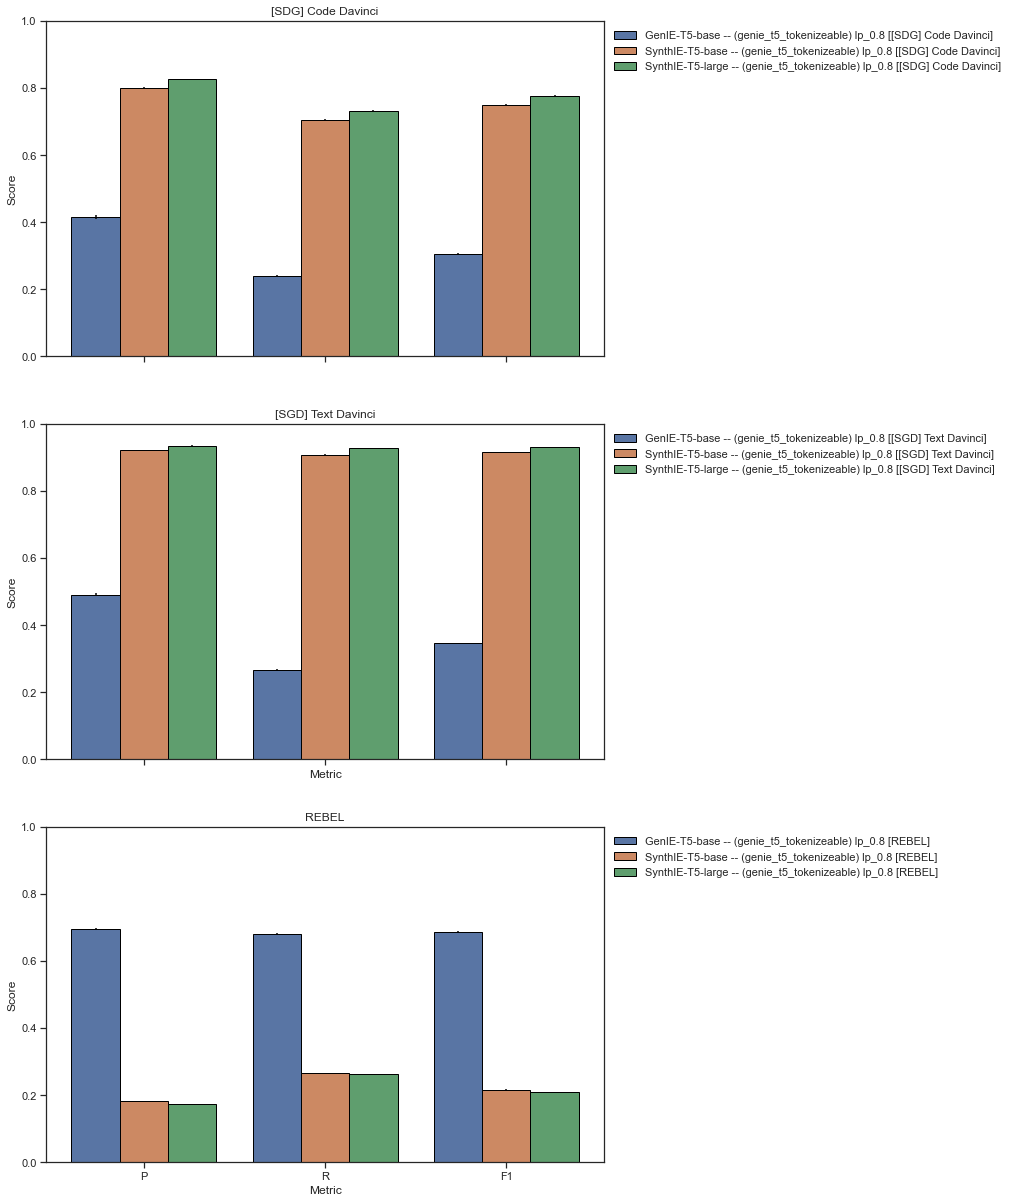

~~~ Macro ~~~~


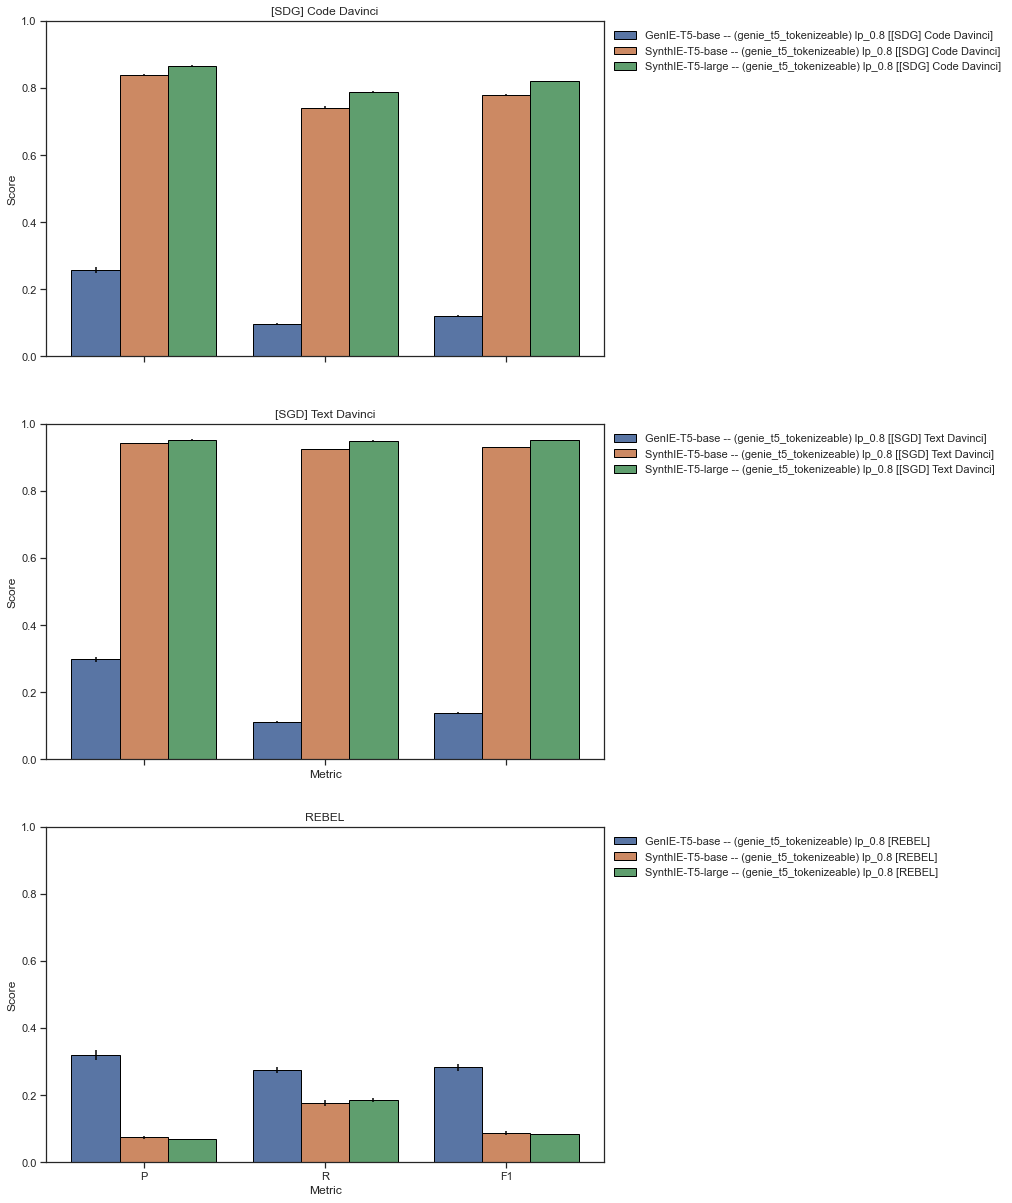

In [36]:
def display_barplots(metrics, metric_labels):
    # Retrieve information
    results_dfs = []
    for exp_id in exp_id2wandb_run_path.keys():
        curr_results = results[exp_id]
        
        if n_bootstrap_samples is None:
            y = [curr_results.get_score(metric_id, per_bucket=False) for metric_id in metrics]
            yerr = None
        else:
            y = []
            yerr = []
            for metric_id in metrics:
                # print(metric_id)
                if confidence_interval_type == "percentile":
                    lower, mean, upper = curr_results.get_percentile_based_ci(metric_id, 
                                                                              confidence_level=confidence_level,
                                                                              n_bootstrap_samples=n_bootstrap_samples,
                                                                              dataset_id=None)
                elif confidence_interval_type == "std":
                    lower, mean, upper = curr_results.get_std_based_ci(metric_id, 
                                                                       n_bootstrap_samples=n_bootstrap_samples, 
                                                                       dataset_id=None)
                else:
                    raise ValueError(f"Unknown confidence interval type: {confidence_interval_type}")
                y.append(mean)
                yerr.append((mean-lower, upper-mean))

            yerr = np.array(yerr).T

        # create a datataframe
        if yerr is not None:
            df = pd.DataFrame({'Metric': metric_labels, 'Score': y, 'ci_score_lower': yerr[0, :], 'ci_score_upper': yerr[1, :]})
        else:
            df = pd.DataFrame({'Metric': metric_labels, 'Score': y})
        
        # required fields
        df['Exp_ID'] = [exp_id] * df.shape[0]
        df['Dataset'] = [retrieve_dataset_name(hydra_configs[exp_id])] * df.shape[0]
        df['Model'] = [exp_id2model_id[exp_id]] * df.shape[0]

        # optional fields
        if results_df_field2getter is not None:
            for field_name, getter in results_df_field2getter.items():
                df[field_name] = [getter(hydra_configs[exp_id])] * df.shape[0]
        results_dfs.append(df)

    results_df = pd.concat(results_dfs, axis=0)
    
    # Massage the data
    dataset_names = results_df['Dataset'].unique()

    per_dataset_results_long = {}
    per_dataset_results_wide = {}

    per_dataset_results_ci_lower = {}
    per_dataset_results_ci_upper = {}

    for dataset_name in dataset_names:
        dataset_long_df = results_df[results_df['Dataset'] == dataset_name].copy()
        # set the error term to the average of the empirical lower and upper confidence interval delta
        # dataset_long_df['Error'] = ((dataset_long_df['ci_score_lower'] + dataset_long_df['ci_score_upper']) / 2)
        # dataset_long_df['Score_with_ci'] = (dataset_long_df['Score']*100).round(2).astype(str) + ' ± ' + (dataset_long_df['Error']*100).round(2).astype(str)
        if n_bootstrap_samples is not None:
            dataset_long_df['Score_with_ci'] = (dataset_long_df['Score']*100).round(2).astype(str) + " [" + ((dataset_long_df['Score']-dataset_long_df['ci_score_lower'])*100).round(2).astype(str) + ", " + ((dataset_long_df['Score'] + dataset_long_df['ci_score_upper'])*100).round(2).astype(str) + "]"
            scores_column = 'Score_with_ci'
        else:
            dataset_long_df['Score_without_ci'] =  (dataset_long_df['Score']*100).round(2).astype(str)
            scores_column = 'Score_without_ci'
        
        per_dataset_results_long[dataset_name] = dataset_long_df

        pivot_index = ['Model']
        if results_df_field2getter is not None:
            pivot_index.extend(list(results_df_field2getter.keys()))
        dataset_wide_df = dataset_long_df.pivot_table(index=pivot_index, columns='Metric', values=scores_column, aggfunc=lambda x: ' '.join(x))
        dataset_wide_df = dataset_wide_df[['P', 'R', 'F1']]
        per_dataset_results_wide[dataset_name] = dataset_wide_df

    results_wide_df = pd.concat(per_dataset_results_wide.values(), keys=per_dataset_results_wide.keys(), names=['Dataset'], axis=1)
    results_wide_df = results_wide_df.sort_index(axis=0, level=results_ordering)
    results_wide_df.columns = pd.MultiIndex.from_tuples([(dataset_name2dataset_label[dataset_name], metric) for dataset_name, metric in results_wide_df.columns.values], names=['Dataset', f'Metric [{int(confidence_level*100)}% CI]'])

    # get a subplot for each dataset
    figsize = (10, 7 * len(dataset_names))
    fig, axes = plt.subplots(len(dataset_names), 1, figsize=figsize, sharex=True, sharey=True)
    
    if len(dataset_names) == 1:
        axes = [axes]

    for ax, dataset_name in zip(axes, dataset_names):
        dataset_results_long_df = per_dataset_results_long[dataset_name]
        # sort the dataframe accoring to the Constraint, Model and LP
        if barplot_hue_ordering is not None:
            dataset_results_long_df = dataset_results_long_df.sort_values(by=barplot_hue_ordering)
        dataset_results_long_df.reset_index(inplace=True, drop=True)

        hue_order = dataset_results_long_df['Exp_ID'].drop_duplicates().values.tolist()
        order = ['P', 'R', 'F1']
        sns.barplot(ax=ax, data=dataset_results_long_df, x='Metric', y="Score", hue='Exp_ID', edgecolor="black", palette='deep', order=order, hue_order=hue_order)

        ax.set_title(dataset_name2dataset_label[dataset_name])
        ax.set_ylabel("Score")
        ax.set_ylim(0,1)
        if ax != axes[0]:
            ax.set_xlabel("Metric")
        else:
            ax.set_xlabel("")

        # remove the box around the legend
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, frameon=False)

        if 'ci_score_lower' in dataset_results_long_df.columns:
            x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
            y_coords = [p.get_height() for p in ax.patches]

            dataset_results_long_df.Exp_ID = pd.Categorical(dataset_results_long_df.Exp_ID, categories=hue_order, ordered=True)
            dataset_results_long_df.Metric = pd.Categorical(dataset_results_long_df.Metric, categories=order, ordered=True)
            error = np.stack([dataset_results_long_df.sort_values(by=['Exp_ID', 'Metric'])['ci_score_lower'].values, dataset_results_long_df.sort_values(by=['Exp_ID', 'Metric'])['ci_score_upper'].values])
            ax.errorbar(x=x_coords, y=y_coords, yerr=error, fmt="none", color="black", capsize=barplot_capsize, zorder=10000)
    
    plt.show()

# Figure for the table above
if PRESENT_QUANTITATIVE_RESULTS:
    print("~~~ Micro ~~~")
    metric_labels = [metric_name2label[metric_id] for metric_id in metrics]
    display_barplots(metrics, metric_labels)

    print("~~~ Macro ~~~~")
    if PRESENT_MACRO_RESULTS:
        macro_metrics = [f"macro_{metric}" for metric in metrics]
        display_barplots(macro_metrics, metric_labels)

In [37]:
def get_predictions_df(exp_ids):
    global n_predictions_to_show
    random_ids = None

    pred_dfs = []

    for exp_id in exp_ids:
        output_dataset = output_datasets[exp_id]

        
        if random_ids is None:
            random_indices = np.random.RandomState(seed).choice(len(output_dataset),  min([n_samples, len(output_dataset)]), replace=False)
            random_ids = set([output_dataset.data[i]['id'] for i in random_indices])

        # random_sample = [output_dataset.data[i] for i in random_indices if output_dataset.data[i]['id'] in random_ids]
        random_sample = [dp for dp in output_dataset.data if dp['id'] in random_ids]

        if present_triplets_in_the_canonical_linearization or not keep_duplicate_triplets:
            if n_predictions_to_show != 1:
                n_predictions_to_show = 1
                print(f"present_triplets_in_the_canonical_linearization={present_triplets_in_the_canonical_linearization} or keep_duplicate_triplets={keep_duplicate_triplets} supported only when n_predictions_to_show=1. Setting n_predictions_to_show=1")

        ids = [sample['id'] for sample in random_sample]
        inputs = [sample['input'] for sample in random_sample]
        targets = [sample['target'] for sample in random_sample]
        predictions = [sample['prediction'][0] if n_predictions_to_show == 1 else sample['prediction'][:n_predictions_to_show] for sample in random_sample]
        
        if present_triplets_in_the_canonical_linearization or not keep_duplicate_triplets:
            targets_triplets = [output_dataset.get_text_triples(target, return_set=(not keep_duplicate_triplets)) for target in targets]
            predictions_triplets = [output_dataset.get_text_triples(prediction, return_set=(not keep_duplicate_triplets)) for prediction in predictions]
            if present_triplets_in_the_canonical_linearization:
                lc = get_linearization_class("fully_expanded")
            else:
                lc = output_dataset.linearization_class
            
            targets = [lc.triplet_list_to_text(triplets)[0] for triplets in targets_triplets]
            predictions = [lc.triplet_list_to_text(triplets)[0] for triplets in predictions_triplets]

        df = pd.DataFrame(list(zip(ids, inputs, targets, predictions)), columns=['id', 'input', 'target', f'prediction_{exp_id}'])
        pred_dfs.append(df)

    predictions_df = reduce(lambda  left,right: pd.merge(left,right,on=['id', 'input', 'target'], how='inner', ), pred_dfs)
    predictions_df.sort_values(by=['id'], inplace=True)
    assert(predictions_df.shape[0] == len(random_ids))
    return predictions_df


def wrap_df_text(df, input_max_col):
    tdf = df.copy()
    tdf['input'] = tdf['input'].str.wrap(input_max_col)
    tdf['target'] = tdf['target'].str.replace("\[e\]|\[et\]", "[e]\\n", regex=True)

    for col in tdf.columns:
        if col.startswith("prediction"):
            if type(tdf[col][0]) == str:
                tdf[col] = tdf[col].str.replace("\[e\]|\[et\]", "[e]\\n", regex=True)
            else:
                tdf[col] = tdf[col].apply(lambda x: "\\n".join([re.sub("\[e\]|\[et\]", "[e]\\n", p) for p in x]))

    display(HTML(tdf.to_html().replace("\\n","<br>")))


if PRESENT_QUALITATIVE_RESULTS:
    seed = 123

    # get the dataset_name for each experiment
    dataset_names = list([retrieve_dataset_name(hydra_configs[exp_id]) for exp_id in exp_ids])

    for dataset_name in set(dataset_names):
        print(f"~~~~ {dataset_name2dataset_label[dataset_name]} ~~~~")
        exp_ids_to_visualize = [exp_id for exp_id, exp_dataset_name in zip(exp_ids, dataset_names) if exp_dataset_name  == dataset_name]
        print(exp_ids_to_visualize)
        predictions_df = get_predictions_df(exp_ids_to_visualize)

        with pd.option_context('display.max_rows', None, 'display.max_columns', None, "display.expand_frame_repr", False, 'display.max_colwidth', None, 'display.width', None):        
            wrap_df_text(predictions_df, 50)

~~~~ [SDG] Code Davinci ~~~~
['SynthIE-T5-large -- (genie_t5_tokenizeable) lp_0.8 [[SDG] Code Davinci]', 'SynthIE-T5-base -- (genie_t5_tokenizeable) lp_0.8 [[SDG] Code Davinci]', 'GenIE-T5-base -- (genie_t5_tokenizeable) lp_0.8 [[SDG] Code Davinci]']


,id,input,target,prediction_SynthIE-T5-large -- (genie_t5_tokenizeable) lp_0.8 [[SDG] Code Davinci],prediction_SynthIE-T5-base -- (genie_t5_tokenizeable) lp_0.8 [[SDG] Code Davinci],prediction_GenIE-T5-base -- (genie_t5_tokenizeable) lp_0.8 [[SDG] Code Davinci]
0,9965,"Beta Aquilae is a binary star located in theconstellation Aquila. Aquila borders Sagittarius,Sagitta, and Serpens.",[s] Beta_Aquilae [r] constellation [o] Aquila_(constellation) [e] [s] Beta_Aquilae [r] instance of [o] Binary_star [e] [s] Aquila_(constellation) [r] shares border with [o] Sagittarius_(constellation) [e] [s] Aquila_(constellation) [r] shares border with [o] Sagitta [e] [s] Aquila_(constellation) [r] shares border with [o] Serpens [e] [s] Binary_star [r] subclass of [o] Star_system [e] [s] Binary_star [r] described by source [o] Internetowa_encyklopedia_PWN [e],[s] Beta_Aquilae [r] constellation [o] Aquila_(constellation) [e] [s] Beta_Aquilae [r] instance of [o] Binary_star [e] [s] Beta_Aquilae [r] instance of [o] Star [e] [s] Aquila_(constellation) [r] shares border with [o] Sagittarius_(constellation) [e] [s] Aquila_(constellation) [r] shares border with [o] Sagitta [e] [s] Aquila_(constellation) [r] shares border with [o] Serpens [e],[s] Beta_Aquilae [r] constellation [o] Aquila_(constellation) [e] [s] Beta_Aquilae [r] instance of [o] Binary_star [e] [s] Beta_Aquilae [r] instance of [o] Star [e] [s] Aquila_(constellation) [r] shares border with [o] Sagittarius_(constellation) [e] [s] Aquila_(constellation) [r] shares border with [o] Sagitta [e] [s] Aquila_(constellation) [r] shares border with [o] Serpens [e],[s] Beta_Aquilae [r] constellation [o] Aquila_(constellation) [e] [s] Aquila_(constellation) [r] instance of [o] Constellation [e]
1,11446,"Loyola College, Belo Horizonte is a business thatoffers a business administration degree and usessocial media. It is modeled after Apple Inc.","[s] Loyola_College,_Belo_Horizonte [r] instance of [o] Business [e] [s] Business [r] studied by [o] Business_administration [e] [s] Business [r] uses [o] Social_media [e] [s] Business [r] model item [o] Apple_Inc. [e]","[s] Loyola_College,_Belo_Horizonte [r] instance of [o] Business [e] [s] Business [r] studied by [o] Business_administration [e] [s] Business [r] uses [o] Social_media [e] [s] Business [r] model item [o] Apple_Inc. [e]","[s] Loyola_College,_Belo_Horizonte [r] instance of [o] Business [e] [s] Business [r] studied by [o] Business_administration [e] [s] Business [r] uses [o] Social_media [e] [s] Business [r] model item [o] Apple_Inc. [e]","[s] Loyola_College,_Belo_Horizonte [r] located in the administrative territorial entity [o] Belo_Horizonte [e]"
2,12806,"Aphrodite is a goddess, who is also known asAphrodite Urania. She is mentioned in theRealencyclopädie der classischenAltertumswissenschaft and appears in the videogame Hades.",[s] Aphrodite [r] epithet [o] Aphrodite_Urania [e] [s] Aphrodite [r] described by source [o] Realencyclopädie_der_classischen_Altertumswissenschaft [e] [s] Aphrodite [r] present in work [o] Hades_(video_game) [e],[s] Aphrodite [r] epithet [o] Aphrodite_Urania [e] [s] Aphrodite [r] described by source [o] Realencyclopädie_der_classischen_Altertumswissenschaft [e] [s] Aphrodite [r] present in work [o] Hades_(video_game) [e],[s] Aphrodite [r] epithet [o] Aphrodite_Urania [e] [s] Aphrodite [r] described by source [o] Realencyclopädie_der_classischen_Altertumswissenschaft [e] [s] Aphrodite [r] present in work [o] Hades_(video_game) [e],[s] Aphrodite [r] instance of [o] Goddess [e]
3,14912,Numerical methods for differential equations areused for differential equations.,[s] Numerical_methods_for_differential_equations [r] use [o] Differential_equation [e],[s] Numerical_methods_for_differential_equations [r] use [o] Differential_equation [e],[s] Numerical_methods_for_differential_equations [r] use [o] Differential_equation [e],[s] Numerical_methods_for_differential_equations [r] facet of [o] Differential_equation [e]
4,18871,Elemen

~~~~ REBEL ~~~~
['SynthIE-T5-large -- (genie_t5_tokenizeable) lp_0.8 [REBEL]', 'SynthIE-T5-base -- (genie_t5_tokenizeable) lp_0.8 [REBEL]', 'GenIE-T5-base -- (genie_t5_tokenizeable) lp_0.8 [REBEL]']


,id,input,target,prediction_SynthIE-T5-large -- (genie_t5_tokenizeable) lp_0.8 [REBEL],prediction_SynthIE-T5-base -- (genie_t5_tokenizeable) lp_0.8 [REBEL],prediction_GenIE-T5-base -- (genie_t5_tokenizeable) lp_0.8 [REBEL]
0,17072,"Borovlyanka () is a rural locality (a selo) inSosnovsky Selsoviet, Zarinsky District, AltaiKrai, Russia.",[s] Borovlyanka [r] country [o] Russia [e] [s] Classification_of_inhabited_localities_in_Russia [r] country [o] Russia [e] [s] Zarinsky_District [r] located in the administrative territorial entity [o] Altai_Krai [e] [s] Zarinsky_District [r] country [o] Russia [e] [s] Altai_Krai [r] contains administrative territorial entity [o] Zarinsky_District [e] [s] Altai_Krai [r] country [o] Russia [e] [s] Russia [r] contains administrative territorial entity [o] Altai_Krai [e],[s] Borovlyanka [r] country [o] Russia [e],[s] Borovlyanka [r] country [o] Russia [e],[s] Borovlyanka [r] country [o] Russia [e] [s] Classification_of_inhabited_localities_in_Russia [r] country [o] Russia [e] [s] Zarinsky_District [r] located in the administrative territorial entity [o] Altai_Krai [e] [s] Zarinsky_District [r] country [o] Russia [e] [s] Altai_Krai [r] contains administrative territorial entity [o] Zarinsky_District [e] [s] Altai_Krai [r] country [o] Russia [e] [s] Russia [r] contains administrative territorial entity [o] Altai_Krai [e]
1,17539,"Richardson, Jr.'s ""A New Topographical Dictionaryof Ancient Rome"", but mostly by the new standard,a completely new work, Margareta Steinby's""Lexicon Topographicum Urbis Romae"" (six volumes,1993–2000).",[s] Lexicon_Topographicum_Urbis_Romae [r] editor [o] Margareta_Steinby [e],[s] Lexicon_Topographicum_Urbis_Romae [r] main subject [o] Ancient_Rome [e] [s] Lexicon_Topographicum_Urbis_Romae [r] author [o] Margareta_Steinby [e],[s] English_language [r] signed form [o] Manually_coded_English [e] [s] English_language [r] uses capitalization for [o] Demonym [e] [s] English_language [r] has tense [o] Simple_past [e] [s] English_language [r] uses capitalization for [o] Religious_denomination [e] [s] English_language [r] uses capitalization for [o] Religious_denomination [e] [s] English_language [r] uses capitalization for [o] Religious_denomination [e] [s] English_language [r] uses capitalization for [o] Religious_denomination [e] [s] English_language [r] uses capitalization for [o] Religious_denomination [e] [s] English_language [r] uses capitalization for [o] Religious_denomination [e],[s] Lexicon_Topographicum_Urbis_Romae [r] author [o] Margareta_Steinby [e]
2,22836,"Here Comes Honey Boo Boo is an American realitytelevision series that aired on TLC featuring thefamily of child beauty pageant contestant Alana""Honey Boo Boo"" Thompson.",[s] Here_Comes_Honey_Boo_Boo [r] genre [o] Reality_television [e],[s] Here_Comes_Honey_Boo_Boo [r] genre [o] Reality_television [e] [s] Here_Comes_Honey_Boo_Boo [r] original broadcaster [o] TLC_(TV_network) [e] [s] Here_Comes_Honey_Boo_Boo [r] country of origin [o] United_States [e],[s] Here_Comes_Honey_Boo_Boo [r] genre [o] Reality_television [e] [s] Here_Comes_Honey_Boo_Boo [r] original broadcaster [o] TLC_(TV_network) [e] [s] Here_Comes_Honey_Boo_Boo [r] country of origin [o] United_States [e],[s] Here_Comes_Honey_Boo_Boo [r] genre [o] Reality_television [e] [s] Here_Comes_Honey_Boo_Boo [r] original broadcaster [o] TLC_(TV_network) [e]
3,25293,"In 1849, he was elected to represent Mason Countyin the lower house of the Kentucky statelegislature.",[s] Kentucky_House_of_Representatives [r] part of [o] Kentucky_General_Assembly [e] [s] Kentucky_General_Assembly [r] has part [o] Kentucky_House_of_Representatives [e],"[s] Mason_County,_Kentucky [r] different from [o] Mason_County,_Illinois [e] [s] Mason_County,_Kentucky [r] different from [o] Mason_County,_Illinois [e] [s] Mason_County,_Kentucky [r] different from [o] Mason_County,_Illinois [e] [s] Mason_County,_Kentucky [r] located in the administrative territorial entity [o] Kentucky [e] [s] Maso

~~~~ [SGD] Text Davinci ~~~~
['SynthIE-T5-large -- (genie_t5_tokenizeable) lp_0.8 [[SGD] Text Davinci]', 'SynthIE-T5-base -- (genie_t5_tokenizeable) lp_0.8 [[SGD] Text Davinci]', 'GenIE-T5-base -- (genie_t5_tokenizeable) lp_0.8 [[SGD] Text Davinci]']


,id,input,target,prediction_SynthIE-T5-large -- (genie_t5_tokenizeable) lp_0.8 [[SGD] Text Davinci],prediction_SynthIE-T5-base -- (genie_t5_tokenizeable) lp_0.8 [[SGD] Text Davinci],prediction_GenIE-T5-base -- (genie_t5_tokenizeable) lp_0.8 [[SGD] Text Davinci]
0,2494,Soavimbahoaka is located in the UTC+03:00 timezone.,[s] Soavimbahoaka [r] located in time zone [o] UTC+03:00 [e],[s] Soavimbahoaka [r] located in time zone [o] UTC+03:00 [e],[s] Soavimbahoaka [r] located in time zone [o] UTC+03:00 [e],[s] Soavimbahoaka [r] located in time zone [o] UTC+03:00 [e]
1,6185,Cancer is a health specialty that falls under thesubclass of Neoplasm. Oncology is the branch ofmedicine focused on the study and treatment ofcancer.,[s] Cancer [r] subclass of [o] Neoplasm [e] [s] Cancer [r] health specialty [o] Oncology [e],[s] Cancer [r] subclass of [o] Neoplasm [e] [s] Cancer [r] health specialty [o] Oncology [e],[s] Cancer [r] subclass of [o] Neoplasm [e] [s] Cancer [r] health specialty [o] Oncology [e],[s] Cancer [r] subclass of [o] Neoplasm [e]
2,6969,"John Hamre, Frederick W. Smith, Leon Panetta, andHelene D. Gayle are all members of the board ofthe Center for Strategic and InternationalStudies.",[s] Center_for_Strategic_and_International_Studies [r] board member [o] John_Hamre [e] [s] Center_for_Strategic_and_International_Studies [r] board member [o] Frederick_W._Smith [e] [s] Center_for_Strategic_and_International_Studies [r] board member [o] Leon_Panetta [e] [s] Center_for_Strategic_and_International_Studies [r] board member [o] Helene_D._Gayle [e],[s] Center_for_Strategic_and_International_Studies [r] board member [o] John_Hamre [e] [s] Center_for_Strategic_and_International_Studies [r] board member [o] Frederick_W._Smith [e] [s] Center_for_Strategic_and_International_Studies [r] board member [o] Leon_Panetta [e] [s] Center_for_Strategic_and_International_Studies [r] board member [o] Helene_D._Gayle [e],[s] Center_for_Strategic_and_International_Studies [r] board member [o] John_Hamre [e] [s] Center_for_Strategic_and_International_Studies [r] board member [o] Frederick_W._Smith [e] [s] Center_for_Strategic_and_International_Studies [r] board member [o] Leon_Panetta [e] [s] Center_for_Strategic_and_International_Studies [r] board member [o] Helene_D._Gayle [e],[s] John_Hamre [r] member of [o] Center_for_Strategic_and_International_Studies [e] [s] Frederick_W._Smith [r] member of [o] Center_for_Strategic_and_International_Studies [e] [s] Leon_Panetta [r] member of [o] Center_for_Strategic_and_International_Studies [e] [s] Helene_D._Gayle [r] member of [o] Center_for_Strategic_and_International_Studies [e]
3,7861,"The Ruskin Galleries are located in England, apart of the United Kingdom.",[s] Ruskin_Galleries [r] located in the administrative territorial entity [o] England [e] [s] Ruskin_Galleries [r] country [o] United_Kingdom [e],[s] Ruskin_Galleries [r] located in the administrative territorial entity [o] England [e] [s] Ruskin_Galleries [r] country [o] United_Kingdom [e],[s] Ruskin_Galleries [r] located in the administrative territorial entity [o] England [e] [s] Ruskin_Galleries [r] country [o] United_Kingdom [e],[s] Ruskin_Galleries [r] country [o] United_Kingdom [e] [s] England [r] country [o] United_Kingdom [e] [s] United_Kingdom [r] contains administrative territorial entity [o] England [e]
4,10245,Jaime Sunye Neto is a Grandmaster (chess) andparticipated in the 37th Chess Olympiad.,[s] Jaime_Sunye_Neto [r] title of chess person [o] Grandmaster_(chess) [e] [s] Jaime_Sunye_Neto [r] participant in [o] 37th_Chess_Olympiad [e],[s] Jaime_Sunye_Neto [r] title of chess person [o] Grandmaster_(chess) [e] [s] Jaime_Sunye_Neto [r] participant in [o] 37th_Chess_Olympiad [e],[s] Jaime_Sunye_Neto [r] title of chess person [o] Grandmaster_(chess) [e] [s] Jaime_Sunye_Neto [r] participant in [o] 37th_Chess_Olympiad [e],[s] Jaime_Sunye_Neto [r] title of chess person [o] Grandmaster_(chess) [e] [s] Jaime_Sunye_Neto [r] participant in [o] 37th_Chess_